In [1]:
import numpy as np
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import nltk
from sklearn.model_selection import train_test_split
import pprint, time

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
from IPython.core.display import Image, display

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams['font.size'] = 12

### __Participants: Alvaro Viejo (100451677), Rodrigo Oliver (100451788), Oscar Montoya (100451858), Miguel Ángel Ponce (100451309)__

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2020

&nbsp;
&nbsp;
&nbsp;
# Lab 8. Hidden Markov Models

&nbsp;
&nbsp;
&nbsp;

**Ignacio Peis**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='https://www.uc3m.es/ss/Satellite?blobcol=urldata&blobkey=id&blobtable=MungoBlobs&blobwhere=1371573953235&ssbinary=true' width=400 />


# 1. Introduction

&nbsp;

**Markov Models** are one of the simplest ways to treat sequential data, by relaxing the i.i.d. (independent and identically distributed) assumption. The joint distribution for a sequence of observations is given by:
$$ p(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_T) = p(\mathbf{x}_{1:T}) = \prod_{t=2}^T p(\mathbf{x}_t | \mathbf{x}_1, ..., \mathbf{x}_{t-1}) $$
where we assume that each observation depends on all previous observations, which can be expressed by means of the product rule.
This expression can be relaxed to obtain simpler models by establishing dependencies only with the previous observation (*first-order Markov chain*) or the two previous ones (*second order Markov chain*).

Suppose we wish to build a model for sequences that is not limited by the Markov assumption to any order and yet that can be specified using a limited number of free parameters. We can achieve this by introducing additional latent variables to permit a rich class of models to be constructed out ot simple components, as we did with mixture distributions. For each observation $\textbf{x}_t$ , we introduce a corresponding latent variable $\textbf{z}_t$, which might be of different type or dimensionality to the observed variable. The joint distribution for this model is given by:
$$ p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T}) = p(\mathbf{z}_1 ) \left[ \prod_{t=2}^T p(\mathbf{z}_t|\mathbf{z}_{t-1}  ) \right] \prod_{t=1}^T p(\mathbf{x}_t |\mathbf{z}_t) $$
If this latent variable is continous, we call the model a *state space model*. In contrast, if the latent variable is discrete, we have a **Hidden Markov Model** and is denoted as **state**, $\mathbf{z}_t \equiv s_t$.




# 2. Hidden Markov Models

&nbsp;

<img src='http://www.tsc.uc3m.es/~ipeis/ML2/hmm.png' width=400 />

&nbsp;

A Hidden Markov Model (HMM) consists of a discrete-time, discrete-state Markov chain (first-order Markov discrete model), with hidden states $s_t \in \{ 1, ..., L \}$, plus an **observation** model $p(\mathbf{y}_t | s_t)$. The joint distribution has the form:
$$ p(\mathbf{y}_{1:T}, s_{1:T}) = p(s_1 ) \left[ \prod_{t=2}^T p(s_t|s_{t-1}  ) \right] \prod_{t=1}^T p(\mathbf{y}_t |s_t) $$
The probabilities of each observation $p(\mathbf{y}_t |s_t)$ given the state is called **emission**. If the data is continuous, it follows a Gaussian distribution:
$$ p(\mathbf{y}_t |s_t) = \mathcal{N} (\mathbf{y}_t | \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i) $$
Hence, for each observation $\mathbf{y}_t$, we have a set of $L$ possible Gaussians, depending on the state $s_t$ that generated the sample. In other terms, a HMM can be seen as a sequential GMM, where the component of each sample depends on the previous one.
The probabilities of the discrete hidden states are defined by the transition matrix, $\mathbf{A}$. Each of its elements $a_{ij}$ defines the probability of state $j$ given that the previous state was $i$. Further, we need a probability for the initial states (as they do not have previous states). This probabilities are called $\boldsymbol{\pi}$.

- $ S = \{ s_1, s_2, ..., s_T : s_t \in 1, ..., L \}  $: hidden state sequence.
- $ Y = \{ \mathbf{y}_1, \mathbf{y}_2, ..., \mathbf{y}_T : \mathbf{y}_t \in \mathbb{R}^M \}  $: observed continuous sequence.
- $ \mathbf{A} = \{ a_{ij}: a_{ij} = p(s_{t+1}=j | s_t = i \} $: state transition probabilities.
- $ \mathbf{B} = \{ b_{i}: p_{b_i}(\mathbf{y}_t) = p(\mathbf{y}_t | s_t = i \} $: observation emission probabilities.
- $ \boldsymbol{\pi} = \{ \pi_i: \pi_i = p(s_1=i) \} $: initial state probability distribution.
- $ \boldsymbol{\theta} = \{ \mathbf{A}, \mathbf{B}, \boldsymbol{\pi} \} $: model parameters.


## 2.1. Inference in HMMs

In graphical models, given the joint distribution, we can perform probabilistic inference. This refers to the task of estimating unknown quantities from known quantities. i.e., the distributions for latent variables given the observations. Provided the HMM model, several inference scenarios might be needed to be solved.

### 2.1.1. The Forwards Algorithm

The forwards algorithm is used with the aim at obtaining the evidence of a sequence, given the sequence $Y$ and the parameters $\theta$: 
$$p(Y | \theta) = \sum_S p(Y, S | \theta)$$
As $S$ is hidden (we do not observe it), we have to infer its probabilities. This is solved by means of the **Forwards algorithm**, which compute the filtered marginals $p(s_t=j | \mathbf{y}_{1:t})$ recursively:
$$ \alpha_t(i) = p(s_t=i | \mathbf{y}_{1:t}) $$

$$ \alpha_1(i) = \pi_i p_{b_i}(\mathbf{y}_1) $$
$$ \alpha_t(i) = \left( \sum_{j=1}^L \alpha_{t-1}(j) a_{ji} \right) p_{b_i}(\mathbf{y}_t) $$

### 2.1.2. The Forwards-backwards Algorithm

The goal is to estimate the probability for state $s_t$ at time $t$, given a sequence of observations $Y$ and the parameters of the model $\theta$. For that purpose, we compute the smoothed marginals, $p(s_t=j | \mathbf{y}_{1:T})$ using offline inference (we know future observations for each time $t$):
$$ \gamma_t(j) = p(s_t | y_{1:T}) = \alpha_t(j) \beta_t(j) $$
where:
$$ \beta_T(i) = 1 $$
$$ \beta_t(i) = \sum_j a_{ij} P_{b_j} (\mathbf{y}_{t+1}) \beta_{t+1}(j)  $$

### 2.1.3. The Viterbi Algorithm


In this case, the objective is obtaining the optimal entire sequence of states given the sequence of observations $Y$ and the parameters $\theta$:
$$ S^* = \underset{S}{argmax} \, p(S |Y, \theta) $$


## 2.2. Learning in HMMs: EM by The Baum-Welch algorithm

In graphical models, we denote as *learning* the computation of the parameters that explain a given set of observations. In HMMs, the parameters $\boldsymbol{\theta} = \{ \boldsymbol{\pi}, \textbf{A}, \textbf{B} \} $ can be obtained by using a special version of the EM algorithm, The Baum-Welch algorithm. The process is the same that for GMMs, with the difference that now we consider the time dependencies. 

### 2.2.1. E-step
The expected complete data log likelihood is given by:

$$ Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{old}) = \sum_{i=1}^L \left( \mathbb{E}[N_i^1] \right) \log{\pi_i} + \\ 
\sum_{i=1}^L \sum_{j=1}^L \mathbb{E} [N_{ij}] \log{a_{ij}} + \\
\sum_{n=1}^N \sum_{t=1}^{T_n} \sum_{i=1}^L p(s_t=i | \mathbf{y}_t, \boldsymbol{\theta}^{old}) \log{p(\mathbf{y}_{n, t} | b_i)}
$$

where the expected counts are given by:
$$ \mathbb{E}[N_i^1] = \sum_{n=1}^N p(s_{n1}=i | \mathbf{y}_n, \boldsymbol{\theta}^{old}) = \sum_{n=1}^N \gamma_{n, 1}(i) \\
\mathbb{E}[N_{ij}] = \sum_{n=1}^N \sum_{t=2}^{T_n} p(s_{n,t-1} = i, s_{n,t} = j | \mathbf{y}_n, \boldsymbol{\theta}^{old}))  = \sum_{n=1}^N \xi_{n,t}(i,j) \\
\mathbb{E}[N_i] = \sum_{n=1}^N \sum_{t=1}^{T_n} p(s_{n,t} = i | s_{n,t} = j | \mathbf{y}_n, \boldsymbol{\theta}^{old}))
$$

This function can be expressed in terms of the **smoothed node and edge marginals**:
$$ \gamma_{n, t}(i) = p(s_t=i | \mathbf{y}_{n, 1:T_n}, \boldsymbol{\theta}) \\
\xi_{n, t}(i, j)  = p(s_{t-1} = i, s_t=j | \mathbf{y}_{n, 1:T_n}, \boldsymbol{\theta}) = \alpha_t(i) a_{ij} P_{b_j}(\mathbf{y}_{t+1}) \beta_{t+1}(j)
$$

These are the two variables that must be computed during the E-step, as we did with the *responsibilities* in the EM algorithm for GMMs.

### 2.2.2. M-step
Given all these computed variables, we can update the parameters $\boldsymbol{\theta} = \{ \boldsymbol{\pi}, \textbf{A}, \textbf{B} \} $ using:
$$ \hat{\pi}_i= \frac{\mathbb{E}[N_i^1]}{N} $$
$$ \hat{a}_{ij}= \frac{\mathbb{E}[N_{ij}]}{\sum_{j'} \mathbb{E}[N_{ij'}]} $$
The emission model will depend on the type of the data. For a Gaussian emission, the parameters for each component will be:
$$ \hat{\boldsymbol{\mu}}_i = \frac{\mathbb{E}[\bar{\mathbf{y}}_i]}{\mathbb{E}[N_i]} \qquad 
\hat{\boldsymbol{\Sigma}}_i = \frac{ \mathbb{E}[(\overline{yy})_i^T] - \mathbb{E}[N_i]\hat{\boldsymbol{\mu}}_i \hat{\boldsymbol{\mu}}_i^T }{ \mathbb{E}[N_i] }
$$ 
where the expected sufficient statistics are
$$ \mathbb{E}[\bar{y}_i] = \sum_{n=1}^N \sum_{t=1}^{T_n} \gamma_{n,t}(i) \mathbf{y}_{n,t} $$
$$ \mathbb{E}[\overline{yy}_i^T] = \sum_{n=1}^N \sum_{t=1}^{T_n} \gamma_{n,t}(i) \mathbf{y}_{n,t} \mathbf{y}_{n,t}^T $$

By the other hands, if the observations are discrete, the emissions follow a Mutinouilli model, and the parameters are a matrix $\mathbf{B}$ where:
$$ \hat{b}_{im} = \frac{\mathbb{E} [M_{im}] }{\mathbb{E} [N_{i}]}$$
where:
$$ \mathbb{E} [M_{im}] = \sum_{n=1}^{N} \sum_{t=1}^{T_n} \gamma_{n,t}(i) \mathbb{I}(y_{n,t}=m) = \sum_{n=1}^{N} \sum_{t:y_{n, t}=l} \gamma_{n,t} (i)$$
and $m$ correspond to the discrete observed varaible.

## 2.3. HMMs with fully observed data

There is another approach for HMMs where we assume that the states are also observed. In this case, inference of the states is not required, as we actually know the values of $S$. We can directly compute the Maximum Likelihood Estimation for $\mathbf{A}$ and $\boldsymbol{\pi}$ with the expressions:

$$ \hat{a}_{ij}= \frac{\mathbb{E}[N_{ij}]}{\sum_{j'} \mathbb{E}[N_{ij'}]} $$
$$ \hat{\pi}_i= \frac{\mathbb{E}[N_i^1]}{N} $$

The transitions $\hat{a}_{ij}$ are obtained as the proportion of observed transitions from state $i$ to $j$ with respect to all the states $i$. The $\hat{\pi}_i$ initial probabilities are simply the proportion of states $i$ with respect to all the observed states. 

In the second part of this notebook we will fit a HMM with fully observed discrete data. For the discrete case, the emissions are given by:
$$ \hat{b}_{im} = \frac{N_{im}^X}{N_i} \qquad N_{im}^X = \sum_{n=1}^{N} \sum_{t=1}^{T_n}  \mathbb{I}(s_{n,t}=i, x_{n,t}=m)$$
The emission $\hat{b}_{im}$ is basically the proportion of times a word $m$ appears with tag $i$ with respect to all the words with tag $i$.

## 2.4. HMMs in hmmlearn

[hmmlearn](https://hmmlearn.readthedocs.io/en/latest/api.html) is a python package that implements the HMM model and its principal applications of inference and learning, and follows scikit-learn API as close as possible, but adapted to sequence data. Its easy interface allows to create HMM models and optimize their parameters using the Baum-Welch algorithm in a few lines of code.

An example of the definition of a HMM, and sampling sequences from the model, is included below. For this model, observations $\textbf{y}_t$ are bidimensional, and we use $L=3$ states.

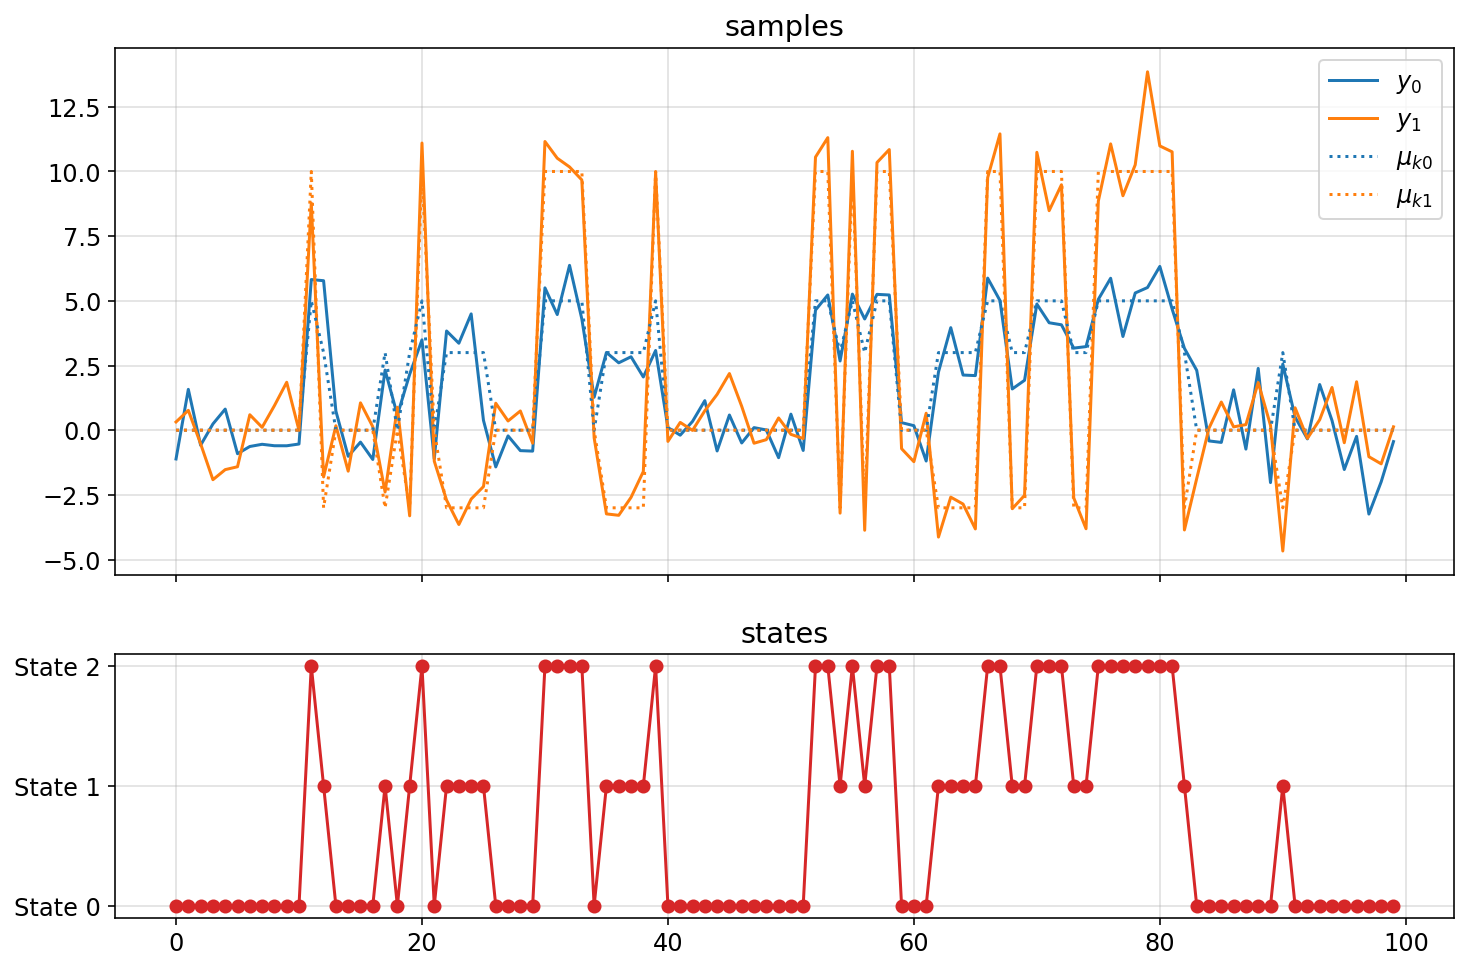

In [4]:
np.random.seed(42)

# Number of states
L=3

# Define the HMM model
model = hmm.GaussianHMM(n_components=L, covariance_type="full")

# SETTING THE PARAMETERS
# Prior probabilities Pi
Pi = np.array([0.6, 0.3, 0.1])
model.startprob_ = Pi

# Transition matrix A
A = np.array([[0.7, 0.2, 0.1],
              [0.3, 0.5, 0.2],
              [0.3, 0.3, 0.4]])
model.transmat_ = A

# Parameters of the state-condition Gaussian densities p(yt|st)
mus = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
Sigmas = np.tile(np.identity(2), (3, 1, 1))
model.means_ = mus
model.covars_ = Sigmas

# Obtain a sequence of 100 samples
Y, S = model.sample(100)

f, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(Y[:, 0], label=r'$y_0$')
ax[0].plot(Y[:, 1], label=r'$y_1$')
ax[0].plot(model.means_[S][:, 0], ':', color='tab:blue', label=r'$\mu_{k0}$')
ax[0].plot(model.means_[S][:, 1], ':', color='tab:orange', label=r'$\mu_{k1}$')
ax[0].grid(alpha=0.4)
ax[0].legend(loc='best')
ax[0].set_title('samples')
ax[1].plot(S, '-o', color='tab:red')
plt.yticks([0, 1, 2], ['State 0', 'State 1', 'State 2'])
ax[1].grid(alpha=0.4)
ax[1].set_title('states')
plt.show()

# 3. Experiments

## 3.1. Human Activity Recognition (HAR)

In Human Activity Recognition, the states $s_t$ can be used to represent activities or gestures and the observations $\mathbf{y}_t$ to features extracted from video or sensors signals. Each activity defines a distribution for the inertial sensors. The signals of an accelerometer will change depending on whether the patient is lying or running, for example.

The [DaLiAc (Daily Life Activities) database](https://www.mad.tf.fau.de/research/activitynet/daliac-daily-life-activities/) consists of data from 19 subjects (8 female and 11 male, age 26 ± 8 years, height 177 ± 11 cm, weight 75.2 ± 14.2 kg, mean ± standard deviation (SD)) that performed 13 daily life activities.

Four sensors were used for data acquisition. Each sensor node was equipped with a triaxial accelerometer and a triaxial gyroscope. Data were sampled with 204.8 Hz Hz and were stored on SD card. The sensor nodes were placed on the left ankle, the right hip, the chest, and the right ankle.


In [5]:
data = pd.read_csv('HAR_data.csv', index_col=0)
activities = ['Sitting', 'Lying', 'Standing', 'Washing Dishes', 'Vacuuming', 'Sweeping', 'Walking',
              'Ascending stairs', 'Descending stairs', 'Treadmill running', 
             'Bicycling on ergometer (50W)', 'Bicycling on ergometer (100W)', 'Rope jumping']
labels = data.iloc[:, -1].values
print(data.shape)
data.head()

(245576, 26)


,Wrist_A1,Wrist_A2,Wrist_A3,Wrist_G1,Wrist_G2,Wrist_G3,Chest_A1,Chest_A2,Chest_A3,Chest_G1,...,Hip_G2,Hip_G3,Ankle_A1,Ankle_A2,Ankle_A3,Ankle_G1,Ankle_G2,Ankle_G3,Activity,Activity_class
0,0.092478,0.14400,-0.009739,231.24,42.410,181.19,-0.13840,-0.85828,0.101680,32.813,...,-15.092,38.214,-0.90671,-0.43698,-0.52616,-91.394,33.158,4.2875,Sitting,0
1,0.057310,0.16003,-0.009739,238.56,51.564,174.59,-0.15410,-0.86636,0.069517,46.727,...,-18.021,37.482,-0.94272,-0.32132,-0.49881,-82.606,36.087,-1.5711,Sitting,0
2,0.022143,0.18408,-0.038329,243.69,59.620,166.17,-0.15410,-0.89867,0.053434,57.346,...,-20.584,37.116,-0.92271,-0.21722,-0.46756,-75.283,37.552,-5.9651,Sitting,0
3,-0.001302,0.20412,-0.030160,246.62,65.112,156.29,-0.16981,-0.90675,0.049414,65.768,...,-23.514,35.285,-0.89070,-0.13626,-0.45193,-69.424,37.552,-8.8945,Sitting,0
4,-0.032562,0.20813,-0.026076,250.64,70.605,145.30,-0.16981,-0.90675,0.081579,69.063,...,-24.246,33.088,-0.89870,-0.10927,-0.48709,-63.566,39.017,-10.3590,Sitting,0


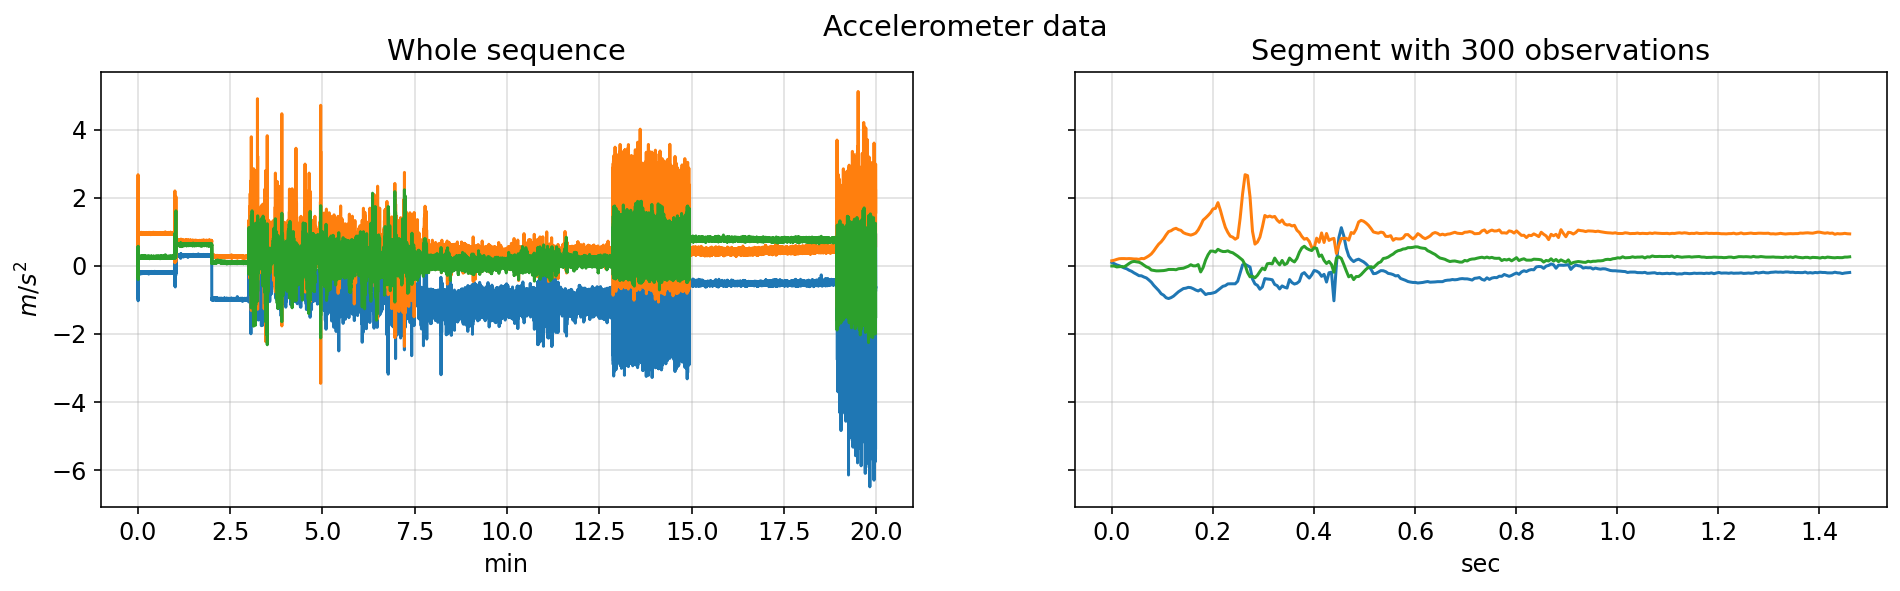

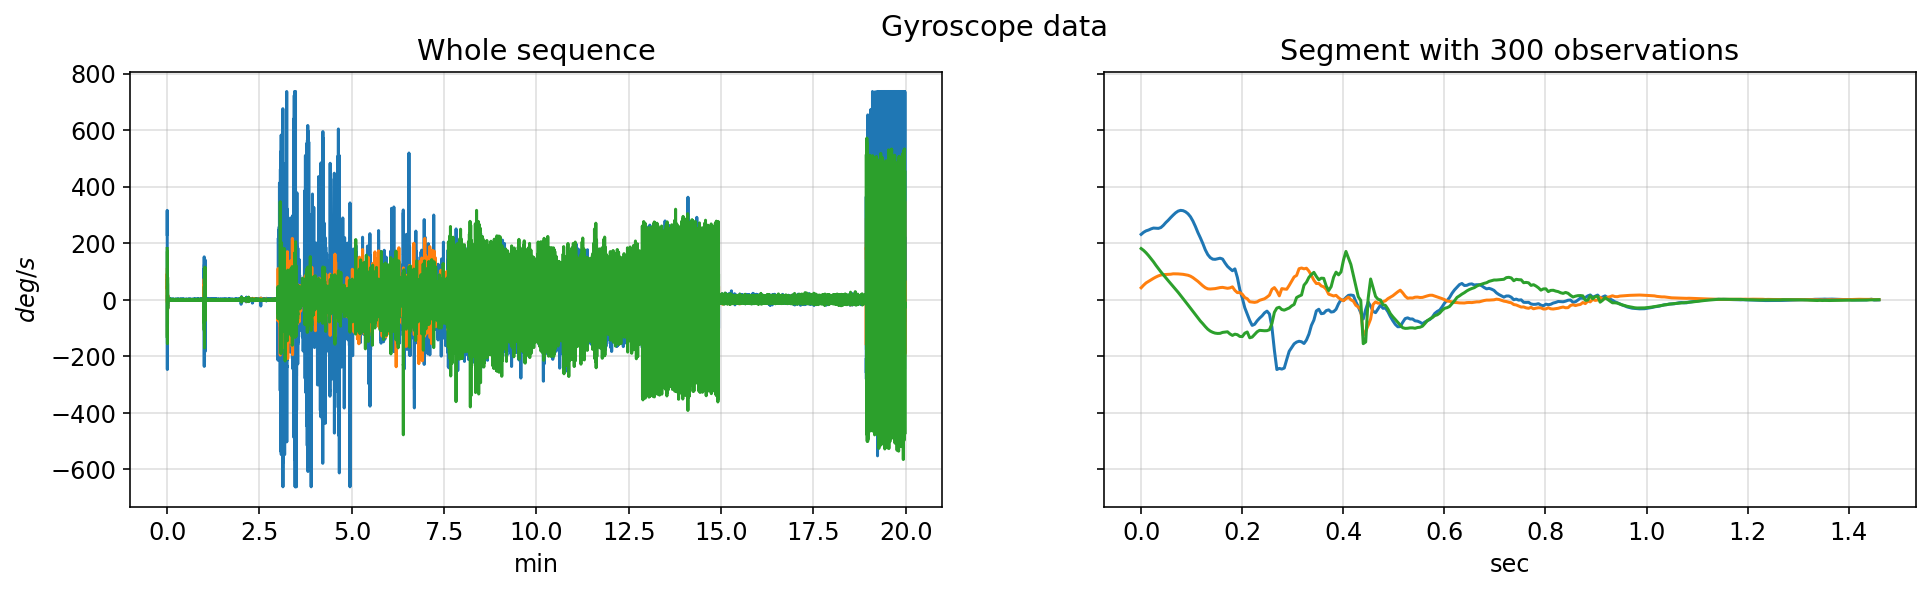

In [6]:
fs = 204.8
f, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)
t = np.arange(data.shape[0])/fs / 60
ax[0].plot(t,  data.iloc[:, 0:3])
ax[0].set_xlabel('min')
ax[0].grid(alpha=0.4)
ax[0].set_title('Whole sequence')
ax[0].set_ylabel(r'$m/s^2$')
ax[1].plot(t[:300]*60, data.iloc[:300, 0:3])
ax[1].set_xlabel('sec')
ax[1].grid(alpha=0.4)
ax[1].set_title('Segment with 300 observations')
plt.suptitle('Accelerometer data')

f, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)
ax[0].plot(np.arange(data.shape[0])/fs / 60,  data.iloc[:, 3:6])
ax[0].set_xlabel('min')
ax[0].grid(alpha=0.4)
ax[0].set_title('Whole sequence')
ax[0].set_ylabel(r'$deg/s$')
ax[1].plot(t[:300]*60, data.iloc[:300, 3:6])
ax[1].set_xlabel('sec')
ax[1].grid(alpha=0.4)
ax[1].set_title('Segment with 300 observations')
plt.suptitle('Gyroscope data')

plt.show()

### 3.1.1. Data Preprocessing

The sampling frequency is $f_s=204.8 Hz$. As it has no sense to guess the performed activity each $1/f_s=4.8 ms$, in HAR, segmentation of the data is performed using windows of $W$ samples. Thus, a segment of 5 seconds correspond to a window of 1024 samples. For each window, we extract the mean and standard deviation as features.

(240, 48)


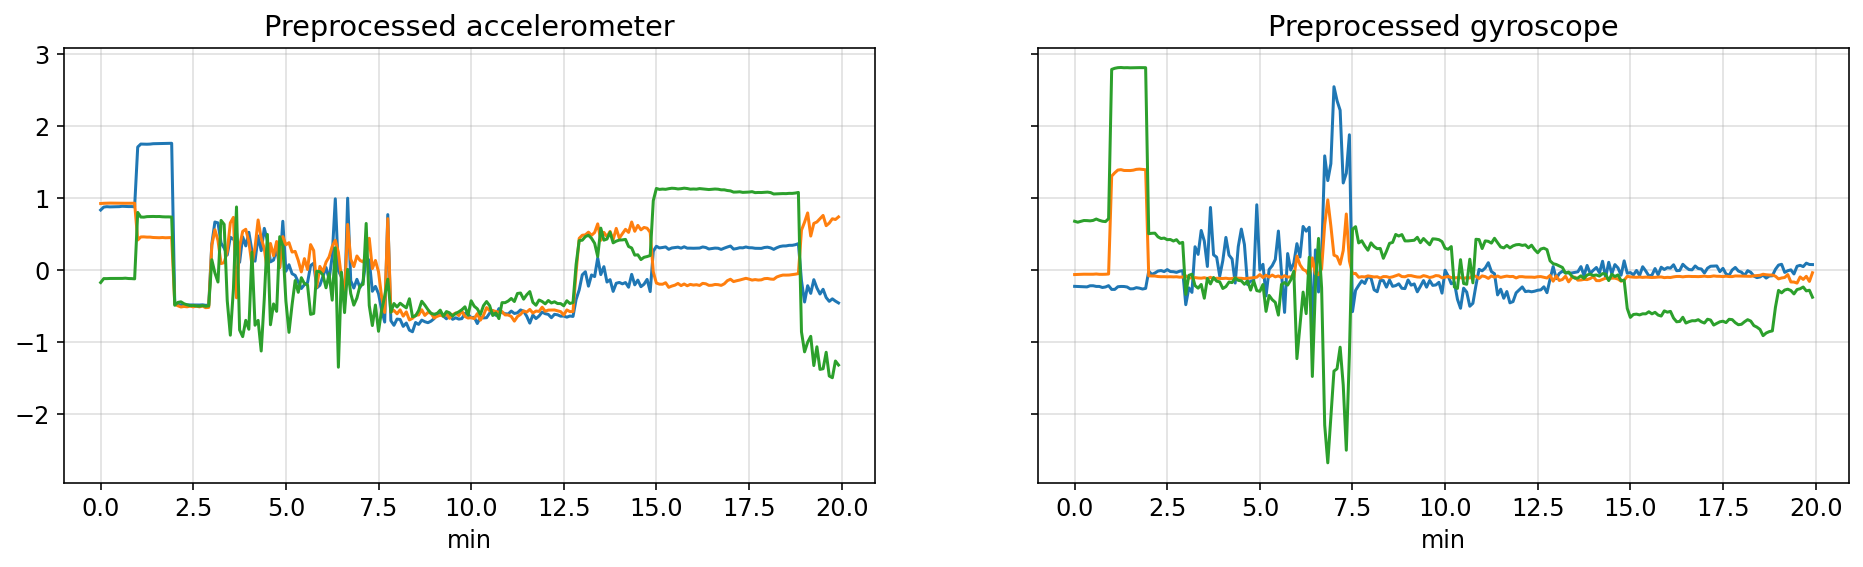

In [7]:
# Normalize data
data_n = data.iloc[:, :-2]
scaler = StandardScaler().fit(data_n)
data_n = scaler.transform(data_n)


fs = 204.8  # 204.8 Hz
Twind = 5 # 5 seconds
Wwind = int(fs * Twind)
nsegments = np.ceil(len(data_n) / Wwind).astype(int)

X = []
acts = []
for s in range(nsegments):
    # Extract features for each segment
    segment = data_n[s*Wwind:(s+1)*Wwind, :]
    mean = np.mean(segment, axis=0)
    std = np.std(segment, axis=0)
    feat = np.concatenate((mean, std))
    X.append(feat)
    
    # Labels
    l = labels[s*Wwind:(s+1)*Wwind]
    counts = np.unique(l, return_counts=True)
    label = counts[0][np.argmax(counts[1])]
    acts.append(label)

X = np.stack(X)
acts = np.stack(acts) # range 0:K-1

print(X.shape)

f, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)
t = np.arange(X.shape[0])*Wwind/fs / 60
ax[0].plot(t, X[:, :3])
ax[0].set_xlabel('min')
ax[0].grid(alpha=0.4)
ax[0].set_title('Preprocessed accelerometer')
ax[1].plot(t, X[:, 6:9])
ax[1].set_xlabel('min')
ax[1].grid(alpha=0.4)
ax[1].set_title('Preprocessed gyroscope');

### 3.1.2. Learning the parameters of the HMM

**TASK1: Using hmmlearn, create a Gaussian HMM model and fit it to the preprocessed data stored in $X$ from the DaLiAc database. Using plt.imshow(), show the transition matrix $A$ as an image, in order to visualize better its elements. Use plt.xticks and plt.yticks to include the activities as labels.**

Fitting a model with 16080 free scalar parameters with only 11520 data points will result in a degenerate solution.
d:\Anaconda3\envs\Massive_Computing\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


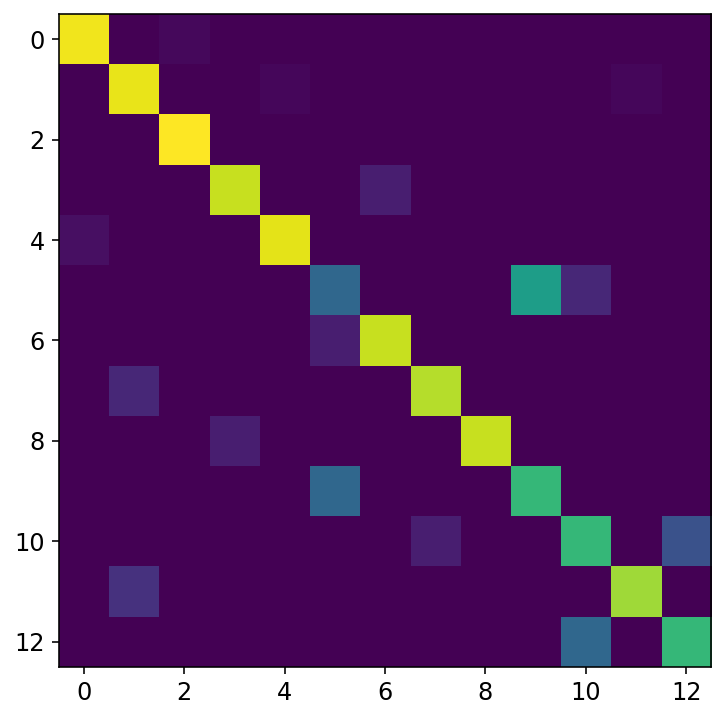

In [8]:
np.random.seed(4396)
model = hmm.GaussianHMM(n_components=len(activities), covariance_type="full")
model.fit(X)

#Transition Matrix
A= model.transmat_

plt.imshow(A)

## Questions

**Q1. Decribe the transition matrix you have obtained, and provide with your intuitions about it.**
- The transition matrix we obtained is clearly pointing to return to the same activity with a much higher probability than changing to another. Therefore our model is correctly associating a state with an activity. Without knowing the activity because the states are random.

**Q2. Is there any state for which the probability of transitioning to other state is considerable? Why?**
- No, because the same as we said before our model seems to predict properly at least that a state is corresponding to only one activity.


### 3.1.2. Inference in HMM: MAP estimation of the states.

**TASK2: Use the corresponding method of hmmlearn to run the Viterbi algorithm that gives you the most probable sequence of states given the signal $X$. Plot the sequence of activities and the decoded states of the HMM. Use the given list of activities for the yticks in the plot.**

*Note: the states of the HMM does not have to be aligned with the labels. For example, state 4 might be associated to activity 1. Use the provided function to align the states with the activities.*

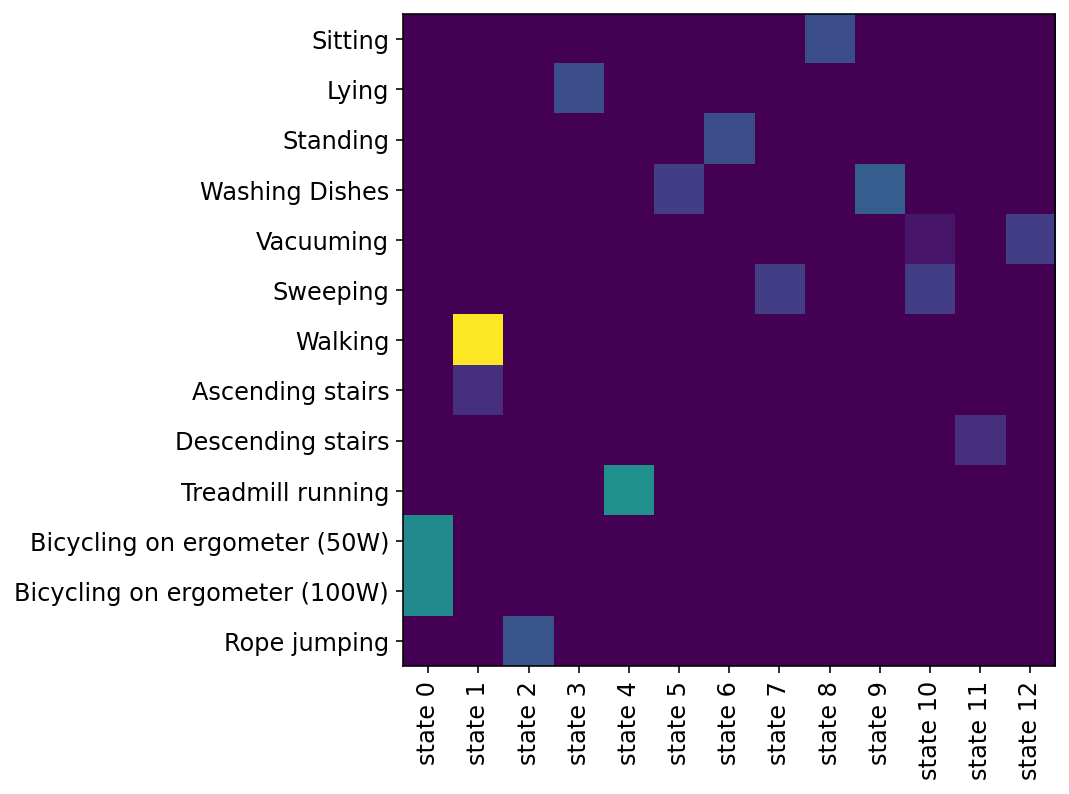

In [9]:

def align_states(acts, states, activities=activities):
    """Align each hidden state with its corresponding class."""
    
    # M_ci show how many points of class c has been associated to state i
    L = len(activities)
    M = confusion_matrix(acts, states)
    plt.figure()
    plt.imshow(M)
    plt.xticks(np.arange(L), ['state '+str(i) for i in range(L)], rotation=90)
    plt.yticks(np.arange(L), activities)
    align = np.argmax(M, axis=0)
    aligned_states = states.copy()
    for s in range(13):
        aligned_states[states==s] = align[s]
    return aligned_states

states = model.predict(X)
aligned = align_states(acts, states, activities=activities)


## Questions

**Q3. Why the state index does not coincide with the class index?**
- Because the class index is hidden and we do not know which activity is each state, that is the problem for the algorithim to obtain the higher probs and assign a possible class for each state.
  
**Q4. Is there any set of activities that the model hardly distinguishes?**
- Clearly walking is related to state 1 with a high probability while for the remaining activities there is not a clear distinguishable state.


## 3.2. Part-Of-Speech (POS) Tagging with Hidden Markov Models

&nbsp;

<img src='http://www.tsc.uc3m.es/~ipeis/ML2/POS.png' width=500 />

&nbsp;

In Natural Language Processing (NLP), associating each word in a sentence with a proper POS (part of speech) is known as POS tagging or POS annotation. POS tags are also known as word classes, morphological classes, or lexical tags. A HMM can be fitted to text data, using the states $S$ for modeling the tags. Hence, for this part, we will fit a **HMM with fully observed data**.

In this experiment, we will use a Multinomial HMM. Features are the appearance of each word in a vocabulary conformed by words from a big database of sentences. Hence, the emission parameters are a big matrix $\mathbf{B}$ with dimensions $L\times M$, where $L$ is the number of states (number of tags) and $M$ is the size of the vocabulary (number of different words in the database).

The dataset for this experiment is the Treebank database, that can be easily download from the [nltk package for NLP in python](https://www.nltk.org/). As the dataset is tagged, we do not have to perform inference, we can just obtain the model parameters by applying the "Fully Observed Data" expressions of section 2.3. The dataset consist on a total of 3914 sentences, and each sentence $n$ is composed by $T_n$ words with their respective tags.


In [10]:
# nltk datasets will be downloaded in "Users/user/nltk_data".

#download the treebank corpus from nltk
nltk.download('treebank')
 
#download the universal tagset from nltk
nltk.download('universal_tagset')

# reading the Treebank tagged sentences
# data contains a list with sentences
# each sentence is a list of tuples with a word and the corresponding tag
data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print('Number of sentences: ' + str(len(data)))

#print each word with its respective tag for first two sentences
print('First two sentences:')
for sent in data[:2]:
    for tuple in sent:
        print(tuple)


[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\tacua\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\tacua\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Number of sentences: 3914
First two sentences:
('Pierre', 'NOUN')
('Vinken', 'NOUN')
(',', '.')
('61', 'NUM')
('years', 'NOUN')
('old', 'ADJ')
(',', '.')
('will', 'VERB')
('join', 'VERB')
('the', 'DET')
('board', 'NOUN')
('as', 'ADP')
('a', 'DET')
('nonexecutive', 'ADJ')
('director', 'NOUN')
('Nov.', 'NOUN')
('29', 'NUM')
('.', '.')
('Mr.', 'NOUN')
('Vinken', 'NOUN')
('is', 'VERB')
('chairman', 'NOUN')
('of', 'ADP')
('Elsevier', 'NOUN')
('N.V.', 'NOUN')
(',', '.')
('the', 'DET')
('Dutch', 'NOUN')
('publishing', 'VERB')
('group', 'NOUN')
('.', '.')


We are going to split the dataset in a 80% of the sentences for training, and 20% for test. All the sentences in these subsets will be concatenated in <code>train_words</code> and <code>test_words</code>, respectively. We are going to build a vocabulary <code>vocab</code> that will contain every word in the train set. The variable <code>tags</code> will contain the $L$ possible tags, which will be out states.

In [11]:
# split data into training and validation set in the ratio 80:20
train_sentences,test_sentences =train_test_split(data,train_size=0.80,test_size=0.20,random_state = 101)

# join all the sentences in train and test sets
train_words = [ tup for sent in train_sentences for tup in sent ]
test_words = [ tup for sent in test_sentences for tup in sent ]
print('Train words: ' + str(len(train_words)))
print('Test words: ' + str(len(test_words)))

# check some of the tagged words.
print('\nFirst 20 training words: ')
print(train_words[:20])

# use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_words}
L = len(tags)
print('\nNumber of tags: ' + str(L))
print(tags)
 
# check total words in vocabulary
vocab = {word for word,tag in train_words}
print('\nNumber of words in the vocabulary: ' + str(len(vocab)))

Train words: 80310
Test words: 20366

First 20 training words: 
[('Drink', 'NOUN'), ('Carrier', 'NOUN'), ('Competes', 'VERB'), ('With', 'ADP'), ('Cartons', 'NOUN'), ('At', 'ADP'), ('last', 'ADJ'), ('count', 'NOUN'), (',', '.'), ('Candela', 'NOUN'), ('had', 'VERB'), ('sold', 'VERB'), ('$', '.'), ('4', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('its', 'PRON'), ('medical', 'ADJ'), ('devices', 'NOUN')]

Number of tags: 12
{'ADP', 'X', 'DET', 'NOUN', 'PRT', 'NUM', 'PRON', 'ADV', '.', 'VERB', 'CONJ', 'ADJ'}

Number of words in the vocabulary: 11052


## 3.2.1. HMM with fully observed data


**TASK3: Build the functions for obtaining the emission and transition probabilities, using expressions of section 2.3.**

In [33]:

def emission(word, tag, train_bag = train_words):
    """Probability B_im that a tag i emits a word m, computed from train_bag"""
    # 1 Count the number of times the given word appears in the training set with the given tag, N_im
    # 2 Count the number of words with the given tag in the training set, N_i
    # B_im = N_im / N_i
    
    N_i = [t[1] for t in train_bag].count(tag)
    # To avoid division by zero error
    if N_i == 0:
        return 0
    else:
        N_im = [w[0] for w in train_bag].count(word)
        
        B_im = N_im/N_i
        return B_im

def transition(tag1, tag2, train_bag = train_words):
    """Probability A_ij of state j (tag2) given that previous state was i (tag1)"""
    # 1 Obtain the tag sequence from training set
    # 2 Count the number of times tag 1 occurs, N_i
    # 3 Count the number of times tag_2 occurs after tag_1, N_ij
    # A_ij = N_ij / N_i
    # print(tag1,tag2)
    N_i = [t[1] for t in train_bag].count(tag1)
    N_ij = [t[1] for index,t in enumerate(train_bag) if train_bag[index-1][1] == tag1].count(tag2)
    # print(N_ij,N_i)
    A_ij = N_ij / N_i 

    return A_ij
        
def transition_matrix(tags, train_bag = train_words):
    """ Build transition matrix A of dimensions LxL from train_bag"""
    # A_ij is the transition probability from tag i to tag j
    
    tags = list(tags) #SET Objects are not iterable
    L = len(tags)
    A = np.zeros((L,L))
    for r in range(L):
        for c in range(L):
            A[r,c] = transition(tags[r],tags[c])
    
    return A

def Viterbi(words, transition_matrix, train_bag = train_words):
    """ Obtain the most probable sequence of tags given a list of words"""
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = transition_matrix.loc['.', tag]
            else:
                transition_p = transition_matrix.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = emission(words[key], tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        
    return list(zip(words, state))

,ADP,X,DET,NOUN,PRT,NUM,PRON,ADV,.,VERB,CONJ,ADJ
ADP,0.016958,0.034548,0.320931,0.323589,0.001266,0.063275,0.069603,0.014553,0.038724,0.008479,0.001012,0.107062
X,0.142226,0.075726,0.056890,0.061695,0.185086,0.003075,0.054200,0.025754,0.160869,0.206419,0.010379,0.017682
DET,0.009918,0.045134,0.006037,0.635906,0.000287,0.022855,0.003306,0.012074,0.017393,0.040247,0.000431,0.206411
NOUN,0.176827,0.028825,0.013106,0.262344,0.043935,0.009144,0.004659,0.016895,0.240094,0.149134,0.042454,0.012584
PRT,0.019569,0.012133,0.101370,0.250489,0.001174,0.056751,0.017613,0.009393,0.045010,0.401174,0.002348,0.082975
NUM,0.037487,0.202428,0.003570,0.351660,0.026062,0.184220,0.001428,0.003570,0.119243,0.020707,0.014281,0.035345
PRON,0.022323,0.088383,0.009567,0.212756,0.014123,0.006834,0.006834,0.036902,0.041913,0.484738,0.005011,0.070615
ADV,0.119472,0.022886,0.071373,0.032196,0.014740,0.029868,0.012025,0.081458,0.139255,0.339022,0.006982,0.130721
.,0.092908,0.025641,0.172192,0.218646,0.002789,0.078210,0.068769,0.052569,0.092372,0.089690,0.060079,0.046132
VERB,0.092357,0.215930,0.133610,0.110589,0.030663,0.022836,0.035543,0.083886,0.034807,0.167956,0.005433,0.066390


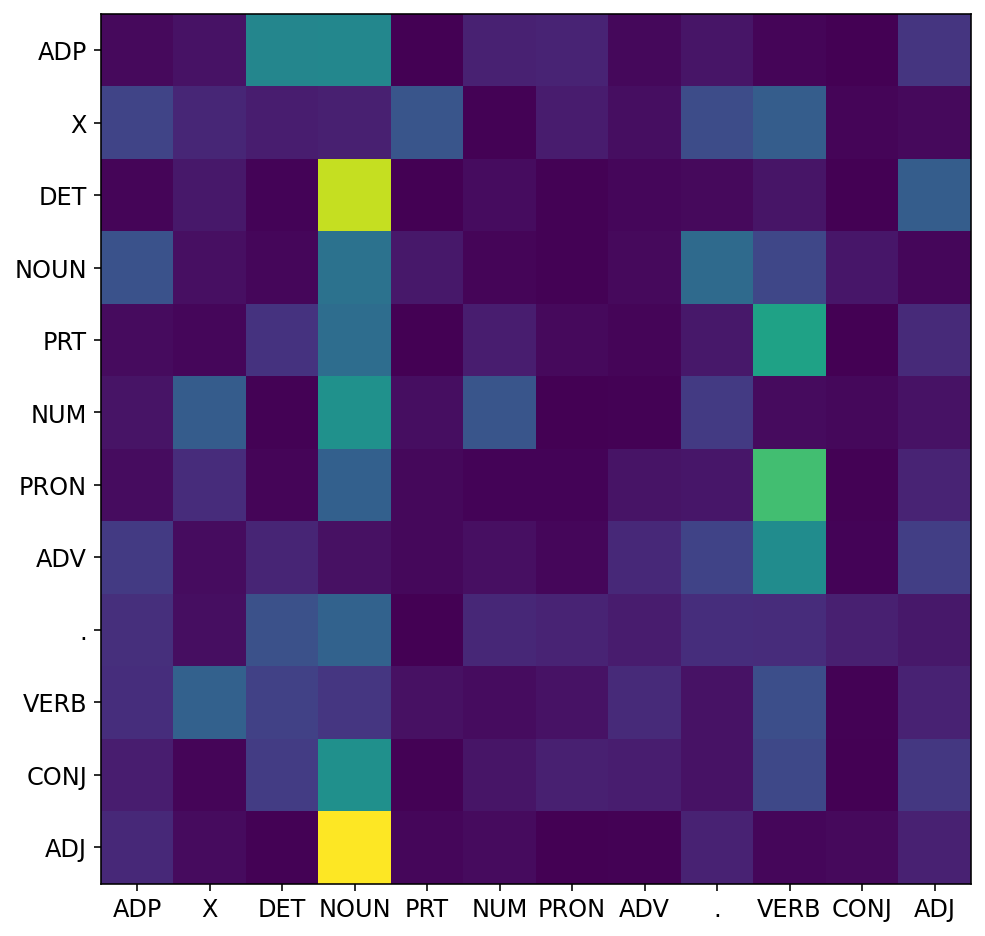

In [34]:
# convert the matrix to a df for better readability
#the table is same as the transition table shown in section 3 of article
A = transition_matrix(tags)
A = pd.DataFrame(A, columns = list(tags), index=list(tags))
plt.figure(figsize=(8, 8))
plt.imshow(A)
plt.xticks(np.arange(len(tags)), list(tags))
plt.yticks(np.arange(len(tags)), list(tags))
display(A)



#### **TASK4: Choosing 10 random sequences from the test set, use the Viterbi function to estimate their tags. Compute the accuracy as the proportion of corrected tagged words.**

In [35]:
import random
from tqdm import tqdm
random.seed(4396)

accuracies = []
randomSeq = [test_sentences[random.randint(0,len(test_sentences) - 1)] for _ in range(10)]
for sent in tqdm(randomSeq):
    words = [w[0] for w in sent]
    randomTags = [t[1] for t in sent]
    viterbiTags = [t[1] for t in Viterbi(words,A)] 
    totalTags = list(zip(randomTags,viterbiTags))
    accuracies.append(sum(r==v for r,v in totalTags)/len(sent)) 

for i,value in enumerate(accuracies):
    print(f'The accuracy for the random sentence {i} is: {value}')

print(f'The average accuracy for this 10 random sentences is: {np.mean(accuracies)}')

100%|██████████| 10/10 [01:06<00:00,  6.67s/it]

The accuracy for the random sentence 0 is: 0.13043478260869565
The accuracy for the random sentence 1 is: 0.09090909090909091
The accuracy for the random sentence 2 is: 0.16666666666666666
The accuracy for the random sentence 3 is: 0.07142857142857142
The accuracy for the random sentence 4 is: 0.11428571428571428
The accuracy for the random sentence 5 is: 0.17142857142857143
The accuracy for the random sentence 6 is: 0.16666666666666666
The accuracy for the random sentence 7 is: 0.0
The accuracy for the random sentence 8 is: 0.03225806451612903
The accuracy for the random sentence 9 is: 0.11764705882352941
The average accuracy for this 10 random sentences is: 0.10617251873336353


## 3.2.2. Sampling sentences

We know how to obtain the parameters of our model when we have fully observed data. As we have a generative model, we can obtain samples from it. In this section, you will build a Multinomial HMM object of hmmlearn and sample sentences.


**TASK5: Obtain the emission matrix $\mathbf{B}$ matrix using the emission function. You should calculate the probability of each word in <code>vocab</code> for each tag.**

*Note: $\mathbf{B}$ will be a huge matrix. This computation might take a while (up to half an hour).*

In [37]:
#############
#           #
# YOUR CODE #
#           #
#############
def emission_matrix(tags=tags, train_bag=train_words):
    # get the list of words and tags
    N_im, N_i = zip(*train_bag) 

    unique_words = set(N_im)
            
    B = np.zeros((len(tags), len(unique_words)))
    
    for i, tag in tqdm(enumerate(tags)):
        for j, word in enumerate(unique_words):
            B[i,j] = emission(word, tag)
            
    return B

B = emission_matrix()

#print(f"{B.shape=}")

print(B)

12it [47:29, 237.43s/it]

[[2.53100481e-04 1.26550240e-04 1.26550240e-04 ... 1.26550240e-04
  1.26550240e-04 2.53100481e-04]
 [3.84393619e-04 1.92196810e-04 1.92196810e-04 ... 1.92196810e-04
  1.92196810e-04 3.84393619e-04]
 [2.87480236e-04 1.43740118e-04 1.43740118e-04 ... 1.43740118e-04
  1.43740118e-04 2.87480236e-04]
 ...
 [1.84162063e-04 9.20810313e-05 9.20810313e-05 ... 9.20810313e-05
  9.20810313e-05 1.84162063e-04]
 [1.09769484e-03 5.48847420e-04 5.48847420e-04 ... 5.48847420e-04
  5.48847420e-04 1.09769484e-03]
 [3.88349515e-04 1.94174757e-04 1.94174757e-04 ... 1.94174757e-04
  1.94174757e-04 3.88349515e-04]]


**TASK6: Compute the parameters $\boldsymbol{\pi}$ as the proportion of the tags in the train set.**

In [40]:
#############
#           #
# YOUR CODE #
#           #
#############
def pi_prop(tags=tags, train_bag=train_words):
    N_i = [t[1] for t in train_bag]
    total_sum = 0
    k = {}
    for j in N_i:
        total_sum += 1
        if j in k:
            k[j] += 1
        else:
            k[j] = 1
    pi = np.zeros(len(k))
    
    for i, ct in enumerate(k.values()):
        pi[i] = ct/total_sum
    
    return pi
            
a = pi_prop(tags, train_words)

print(f"{a=}")

print(sum(a)) # Should sum up to 1

a=array([0.28596688, 0.135226  , 0.09839372, 0.06412651, 0.11606276,
       0.03487735, 0.06478645, 0.02733159, 0.08662682, 0.02268709,
       0.03181422, 0.03210061])
1.0


**TASK7: Build a Multinomial HMM object with the computed parameters and print 30 words sampled from it.**

In [41]:
from hmmlearn.hmm import MultinomialHMM

#############
#           #
# YOUR CODE #
#           #
#############

multimodel = MultinomialHMM(n_components=L)
multimodel.startprob_ = pi_prop(tags, train_words)

multimodel.transmat_ = transition_matrix(tags)

multimodel.emissionprob_ = B

Y, S = multimodel.sample(30)



In [48]:
#print(Y)
# print(f"{Y=}")
# print(f"{S=}")
words, _ = zip(*train_words)
# #y_list = Y.tolist()
y_list = list(np.concatenate(Y).flat)
s_list = S.tolist()

for i in y_list:
    print(words[i], end=" ")

-- regular chief machinists two , story of a *-1 to *-1 , exhibition , income , time 3\/8 Buick to whom price stock two Trotter directors stock 0 two 

## Questions

**Q5. Do the sampled sequences follow a correct grammatical structure?**
- Except for some expecial characters, the sampled sequences do seem to follow some kind of grammatical structure.

**Q6. Do the sampled sequences have a properly semantic content? Why?**
- No, they do not. This is because the model is not trained por this specific task.


## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

